In [58]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from PyEMD.EMD import EMD
from scipy.signal import hilbert
import pywt

from numpy.fft import fft, ifft, fftshift, ifftshift
from scipy.signal import stft
from scipy.signal import periodogram

In [2]:
df = pd.read_csv('D:/Study/Education/Projects/DataFlow/DataFlow_2026/FomoKaguya2026/data/processed/train.csv')

In [3]:
def agg_df(df, interval = '1min'): 
    '''
    Create an aggregate dataframe based on the original input dataframe
    The resulting dataframe contains the resampled time (1min, 5min, 15min,....), the sum of file size and the number of Request status in that interval

    Input: 
        df: original df (from read_csv)

    Output: 
        df_agg: the resulting df
    '''

    df['time'] = pd.to_datetime(df['time'])
    df['status'] = df['status'].astype(int)
    df['size'] = df['size'].astype(float)

    status_counts = (
        df
        .set_index("time")
        .groupby([pd.Grouper(freq=interval), "status_label"])
        .size()
        .unstack(fill_value=0)
    )

    size_agg = (
        df
        .set_index("time")
        .groupby(pd.Grouper(freq=interval))["size"]
        .sum()
    )

    mean_size = size_agg.median()

    df_agg = (
        size_agg
        .to_frame("size")
        .join(status_counts, how="left")
        .fillna(mean_size)
        .reset_index()
    )

    df_agg['anomaly'] = df_agg['size'] == 0

    df_agg.loc[df_agg['anomaly'], 'size'] = mean_size

    df_agg['log_time'] = np.log(df_agg['size'])

    df_agg['log_time'] = (
        df_agg['log_time']
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0)
    )

    return df_agg

In [4]:
df_5min = agg_df(df, '5min')

In [5]:
df_5min

,time,size,Error,No Change,Not Found,Redirected,Success,anomaly,log_time
0,1995-07-01 00:00:00,5277675.0,0.0,19.0,1.0,14.0,267.0,False,15.478996
1,1995-07-01 00:05:00,5041043.0,0.0,11.0,0.0,16.0,240.0,False,15.433124
2,1995-07-01 00:10:00,6111846.0,0.0,25.0,4.0,15.0,198.0,False,15.625739
3,1995-07-01 00:15:00,4559748.0,0.0,21.0,4.0,10.0,247.0,False,15.332778
4,1995-07-01 00:20:00,7262385.0,0.0,16.0,0.0,8.0,295.0,False,15.798219
...,...,...,...,...,...,...,...,...,...
15259,1995-08-22 23:35:00,2410781.0,0.0,16.0,0.0,4.0,107.0,False,14.695461
15260,1995-08-22 23:40:00,3383983.0,0.0,7.0,0.0,1.0,111.0,False,15.034564
15261,1995-08-22 23:45:00,1618155.0,0.0,4.0,0.0,0.0,124.0,False,14.296797
15262,1995-08-22 23:50:00,1169948.0,0.0,5.0,2.0,1.0,129.0,False,13.972470


### HSA

In [20]:
signal = df_5min['log_time'].values 

emd = EMD()
imfs = emd(signal)

print(f"Number of IMFs: {imfs.shape[0]}")

# plt.figure(figsize=(8, 1*(imfs.shape[0] + 1)))

# plt.subplot(imfs.shape[0] + 1, 1, 1)
# plt.plot(df_5min['time'], df_5min['size'], label='Original Price')
# plt.title('Original Price')
# plt.xlabel('time')
# plt.ylabel('Price')
# plt.legend()

# # Plot all IMFs
# for i in range(imfs.shape[0]):
#     plt.subplot(imfs.shape[0] + 1, 1, i + 2)
#     plt.plot(df_5min['time'], imfs[i])
#     plt.title(f'IMF {i + 1}')
#     plt.xlabel('time')
#     plt.ylabel(f'IMF {i + 1}')

# plt.tight_layout()
# plt.show()

Number of IMFs: 12


In [21]:
t = (df_5min['time'] - df_5min['time'].iloc[0]).dt.total_seconds().values

analytic_imfs = hilbert(imfs, axis=1)
amplitude_envelope = np.abs(analytic_imfs) 
instantaneous_phase = np.unwrap(np.angle(analytic_imfs))
instantaneous_frequency = np.diff(instantaneous_phase, axis=1) / (2.0*np.pi*np.diff(t)[0])

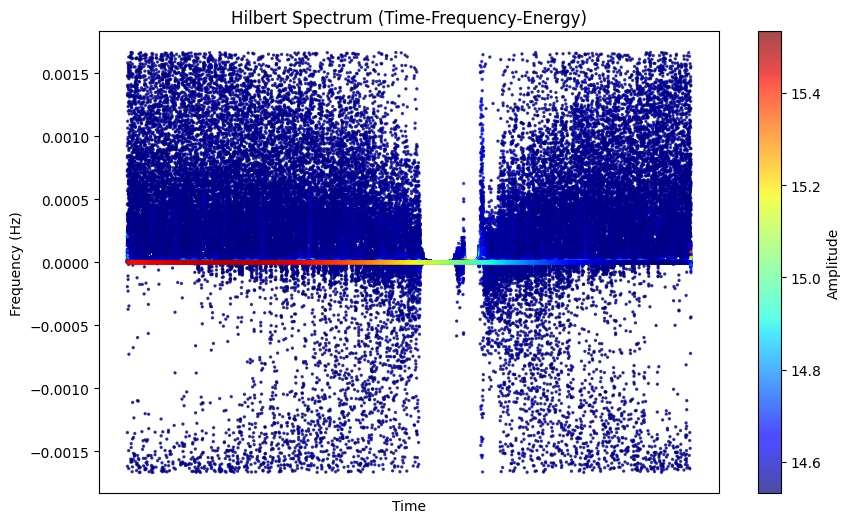

In [22]:
plt.figure(figsize=(10,6))
for i in range(len(imfs)):
    plt.scatter(
        t[1:],                                # length N-1
        instantaneous_frequency[i],           # also length N-1
        c=amplitude_envelope[i,1:],           # length N-1
        cmap='jet', s=2, alpha=0.7
    )
    
# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())         # show every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # format as YYYY
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())        # show months as minor ticks

plt.title("Hilbert Spectrum (Time-Frequency-Energy)")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Amplitude")
plt.show()

### Wavelet

In [32]:
signal = df_5min['size'].values.astype(float)

wavelet = 'db4'   # Daubechies 4 
coeffs = pywt.dwt(signal, wavelet)

cA, cD = coeffs  # Approximation and Detail coefficients

In [33]:
signal = df_5min['size'].values.astype(float)

# Time axis (seconds)
dt = 5 * 60  # 5 minutes
t = np.arange(len(signal)) * dt

In [52]:
# Scales (controls frequency resolution)
scales = np.arange(1, 256)

# Use Morlet mother wavelet
coeffs, freqs = pywt.cwt(
    signal,
    scales=scales,
    wavelet='cmor1.5-1.0',
    sampling_period=dt
)

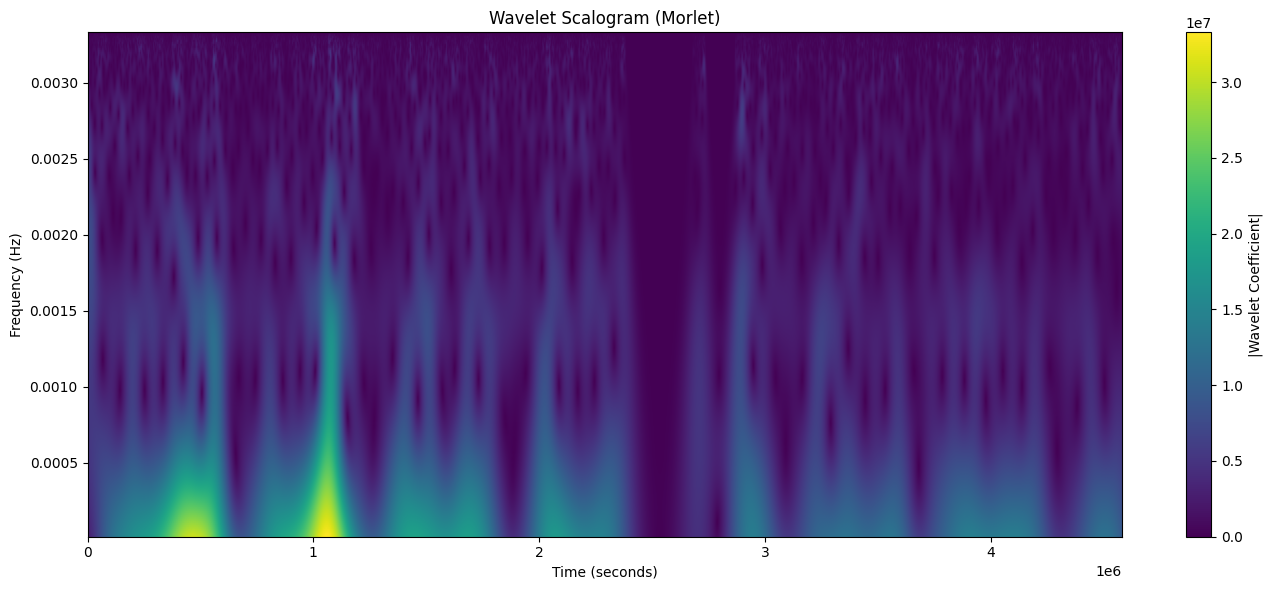

In [53]:
plt.figure(figsize=(14, 6))

plt.imshow(
    np.abs(coeffs),
    extent=[t[0], t[-1], freqs[-1], freqs[0]],
    aspect='auto'
)

plt.colorbar(label='|Wavelet Coefficient|')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Wavelet Scalogram (Morlet)')

plt.tight_layout()
plt.show()

#### Global Spectrum

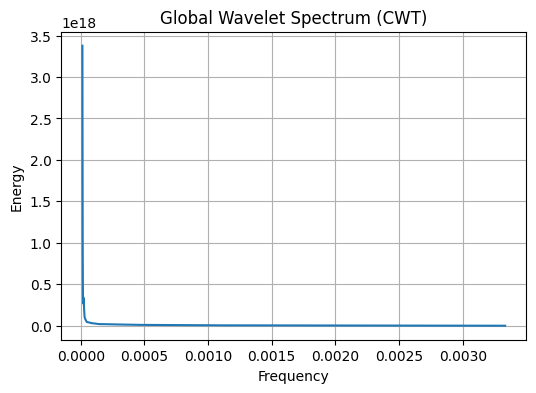

In [56]:
plt.figure(figsize=(6, 4))
plt.plot(freqs, global_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Energy")
plt.title("Global Wavelet Spectrum (CWT)")
plt.grid(True)
plt.show()


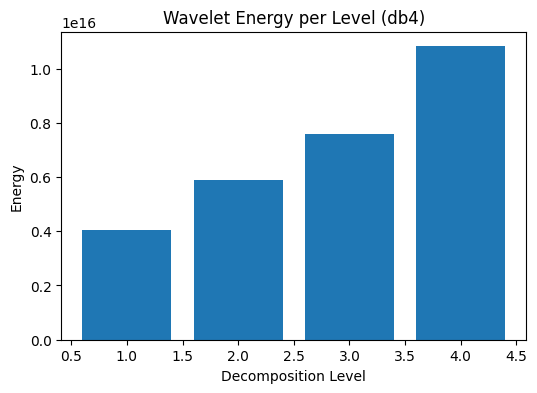

In [57]:
coeffs = pywt.wavedec(signal, wavelet='db4', level=4)

# coeffs = [cA4, cD4, cD3, cD2, cD1]
detail_coeffs = coeffs[1:]

global_spectrum = [np.sum(np.abs(c)**2) for c in detail_coeffs]

plt.figure(figsize=(6, 4))
plt.bar(range(1, len(global_spectrum)+1), global_spectrum)
plt.xlabel("Decomposition Level")
plt.ylabel("Energy")
plt.title("Wavelet Energy per Level (db4)")
plt.show()


### FFT (and STFT)

In [59]:
signal = df_5min['size'].values.astype(float)

# Remove mean first
signal = signal - signal.mean()

In [60]:
dt = 5 * 60            # seconds
fs = 1 / dt            # sampling frequency (Hz)
N = len(signal)        # number of samples

fft_vals = np.fft.fft(signal)
freqs = np.fft.fftfreq(N, d=dt)

#Keep positive frequencies
mask = freqs > 0
fft_vals = fft_vals[mask]
freqs = freqs[mask]

amplitude = np.abs(fft_vals) / N

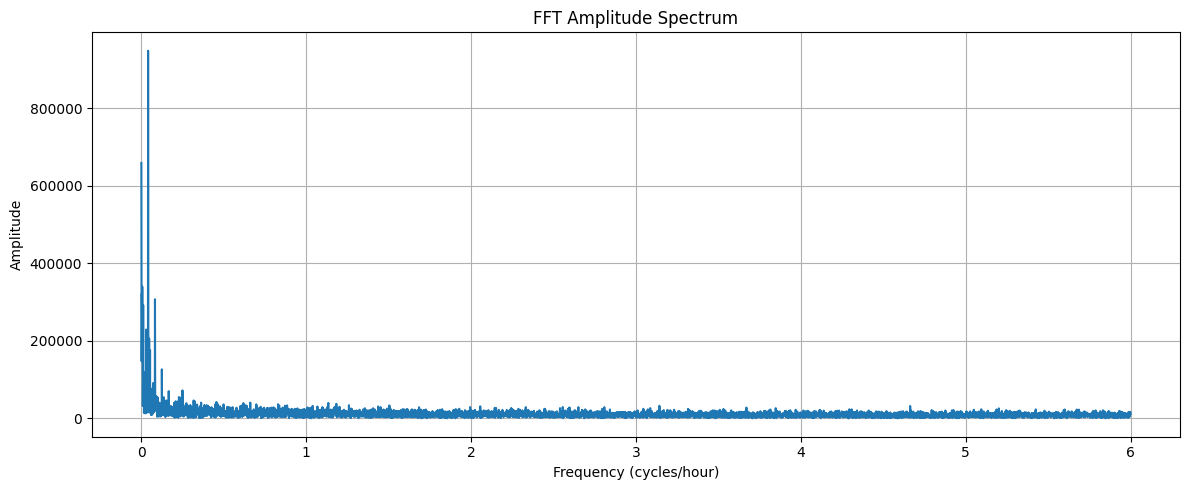

In [40]:
freqs_per_hour = freqs * 3600

plt.figure(figsize=(12, 5))
plt.plot(freqs_per_hour, amplitude)
plt.xlabel('Frequency (cycles/hour)')
plt.ylabel('Amplitude')
plt.title('FFT Amplitude Spectrum')
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
freqs, psd = periodogram(
    signal,
    fs=fs,
    window='hann',
    scaling='density'
)

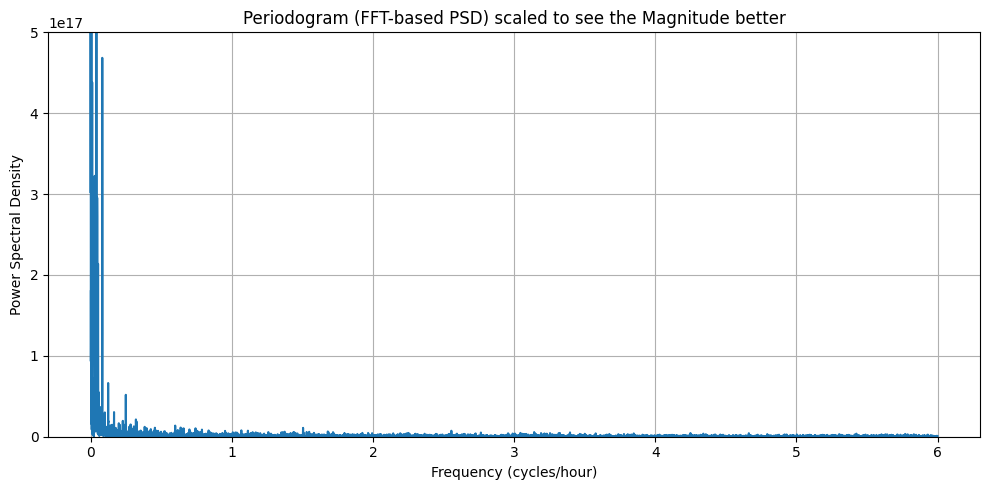

In [68]:
freqs_cph = freqs * 3600

plt.figure(figsize=(10, 5))
plt.plot(freqs_cph, psd)
plt.xlabel("Frequency (cycles/hour)")
plt.ylabel("Power Spectral Density")
plt.title("Periodogram (FFT-based PSD) scaled to see the Magnitude better")
plt.grid(True)
plt.ylim(0, 0.5*1e18)
plt.tight_layout()
plt.show()

#### STFT and Spectrogram

In [48]:
signal = df_5min['size'].values.astype(float)

dt = 5 * 60          # seconds
fs = 1 / dt          # Hz

f, t_stft, Zxx = stft(signal, fs=fs, nperseg=256)

freq_limit = 0.0002
freq_mask = f <= freq_limit

f_lim = f[freq_mask]
Zxx_lim = Zxx[freq_mask, :]

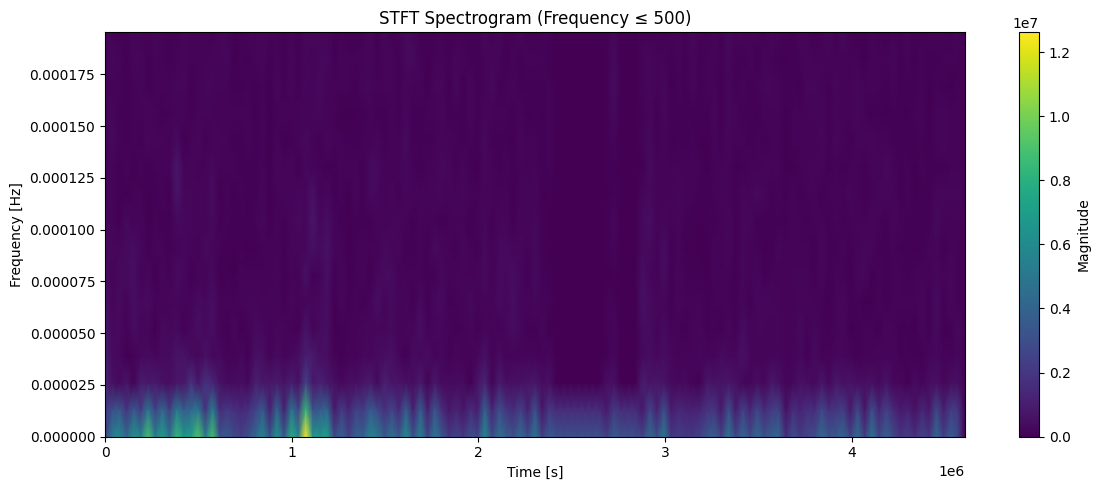

In [49]:
plt.figure(figsize=(12, 5))
plt.pcolormesh(
    t_stft,
    f_lim,
    np.abs(Zxx_lim),
    shading='gouraud'
)
plt.title("STFT Spectrogram (Frequency ≤ 500)")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.colorbar(label="Magnitude")
plt.tight_layout()
plt.show()
